# **An LSTM-based model that incorporates pre-trained GloVe word embeddings.**

# **1. Importing Required Libraries**

This section loads the necessary libraries for preprocessing, model building, and evaluation.

In [1]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# **2. Dataset Preparation**

This section loads the IMDB dataset, restricts the vocabulary size, and pads sequences for uniform input length.

In [2]:
max_features = 10000
maxlen = 500

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [4]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [5]:
print(x_train.shape)
print(x_test.shape)


(25000, 500)
(25000, 500)


# **3. Loading GloVe Embeddings**

**Embedding Matrix:** Maps each word in the vocabulary to its corresponding GloVe vector.

**Fixed Embeddings:** The matrix is loaded into the Embedding layer, and its weights are frozen.

In [6]:
def load_glove_embeddings(file_path, word_index, embedding_dim, max_features):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

    # Create embedding matrix
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i < max_features:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [7]:
word_index = imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

In [8]:
embedding_dim = 100
lstm_units = 32

In [9]:
glove_file_path = r"C:\Users\Wasseem\Desktop\project\glove.6B.100d.txt"  # Path to GloVe file
embedding_matrix = load_glove_embeddings(glove_file_path, word_index, embedding_dim, max_features)

Loaded 400000 word vectors from GloVe.


# **4. Model Definition - Version 2 (with GloVe Embeddings)**

Here, the model incorporates pre-trained GloVe word embeddings for improved initialization.

**Input Layer:** Accepts integer-encoded sequences of fixed length.

**Pre-trained Embeddings:** Enhance feature representations, leading to better performance.

**Trainable=False:** Prevents fine-tuning of GloVe weights, preserving their original semantic structure.

**Dropout Layers:** Reduce overfitting by randomly deactivating neurons during training.

**LSTM Layer:** Captures sequential patterns in text.

**Dense Output Layer:** A single neuron with a sigmoid activation for binary classification.

In [10]:
def My_model_with_glove(max_features, embedding_dim, maxlen, embedding_matrix):
    input_layer = Input(shape=(maxlen,), dtype='int32')
    embedding_layer = Embedding(
        input_dim=max_features,
        output_dim=embedding_dim,
        input_length=maxlen,
        weights=[embedding_matrix],
        trainable=False
    )(input_layer)
    dropout_layer = Dropout(0.2)(embedding_layer)
    lstm_layer = LSTM(units=lstm_units, return_sequences=False)(dropout_layer)
    dropout_layer_2 = Dropout(0.2)(lstm_layer)
    output_layer = Dense(units=1, activation='sigmoid')(dropout_layer_2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [11]:
model = My_model_with_glove(max_features, embedding_dim, maxlen, embedding_matrix)
model.summary()

c:\Users\Wasseem\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,017,057 (3.88 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

# **5. Model Training and Evaluation - Version 2**

## **Loss Function:**
binary_crossentropy measures the difference between predicted and true labels for binary classification.

## **Optimizer:**
rmsprop optimizes weights during training.

## **Callbacks:**
### **ModelCheckpoint:**
Saves the best model based on validation accuracy.

### **ReduceLROnPlateau:**
Dynamically reduces the learning rate when validation loss plateaus.

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model_7.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, verbose=1)

In [12]:
batch_size = 32
epochs = 15

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_split = 0.2,
    callbacks=[checkpoint,reduce_lr]
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6034 - loss: 0.6504
Epoch 1: val_accuracy improved from -inf to 0.75380, saving model to best_model_7.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 113ms/step - accuracy: 0.6035 - loss: 0.6503 - val_accuracy: 0.7538 - val_loss: 0.5431 - learning_rate: 0.0010
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7678 - loss: 0.4995
Epoch 2: val_accuracy improved from 0.75380 to 0.80060, saving model to best_model_7.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.7678 - loss: 0.4995 - val_accuracy: 0.8006 - val_loss: 0.4473 - learning_rate: 0.0010
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8020 - loss: 0.4410
Epoch 3: val_accuracy improved from 0.80060 to 0.82420, saving model to best_model_7.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8020 - loss: 0.4410 - val_accuracy: 0.8242 - val_loss: 0.3986 - learning_rate: 0.0010
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━

# **6. Visualization of Metrics - Version 2**

**Training Accuracy/Loss:** Tracks performance on the training set.

**Validation Accuracy/Loss:** Tracks generalization performance on unseen data.

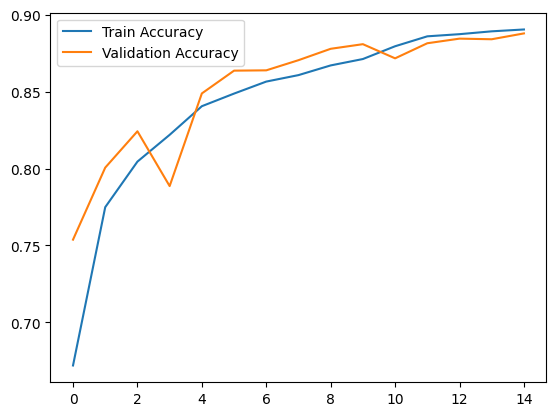

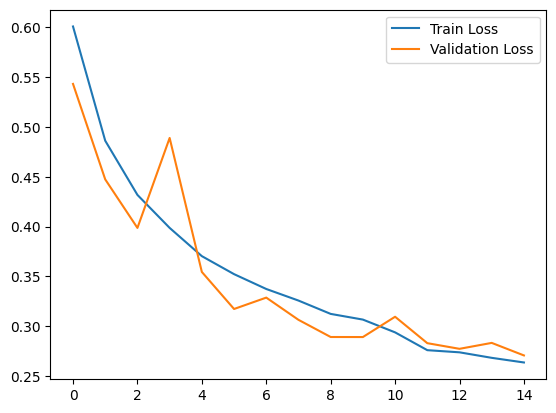

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# **7. Evaluating the model using test set - Version 2**

In [ ]:
# Evaluate the model
print("Evaluating model...")
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating model...
Test Loss: 0.2661
Test Accuracy: 0.8888


In [ ]:
sample = x_test[1:2]
prediction = model.predict(sample)
print(f"Predicted Sentiment: {'Positive' if prediction[0][0] > 0.5 else 'Negative'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted Sentiment: Positive


In [ ]:
print(y_test[1:2])
print(f"Real Sentiment: {'Positive' if y_test[1:2] > 0.5 else 'Negative'}")

[1]
Real Sentiment: Positive
